<h1><center> Kaggle Competition: [New York City Taxi Fare Prediction](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction)</center></h1>

---
# 1. Data Ingestion & Data Cleaning

## 1.1 Data Ingestion

In [1]:
import math
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
import subprocess
import seaborn as sns
sns.set()

# Track how long does this kernel takes to execute completely
import time
start_time = time.time()

In [2]:
# Try to read just 5 rows to check if "data/train.csv" was downloaded:
try:
    train_df = pd.read_csv('data/train.csv', nrows=5)   # total number of rows: 55423857
    display(train_df.head())
except FileNotFoundError:
    print('>>> You must download train.csv from: https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/download/train.csv')
    exit(0)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


#### Tricks to load the data and decrease memory footprint significantly

In [3]:
# set column types to optimize memory usage
col_types = {
    'fare_amount': 'float32',
    'pickup_datetime': 'str', 
    'pickup_longitude': 'float32',
    'pickup_latitude': 'float32',
    'dropoff_longitude': 'float32',
    'dropoff_latitude': 'float32',
    'passenger_count': 'uint8'
}

new_cols = list(col_types.keys())

In [4]:
def get_raw_dataframe(read_size=0):   
    # Method #1: read the entire DataFrame from the disk
    if (read_size == 0):
        df_list = [] # list to hold the batch dataframe
        for df_chunk in tqdm(pd.read_csv('data/train.csv', usecols=new_cols, dtype=col_types, chunksize=5000000)): # loads 5M rows each iteration
            df_chunk['pickup_datetime'] = df_chunk['pickup_datetime'].str.slice(0, 16)
            df_chunk['pickup_datetime'] = pd.to_datetime(df_chunk['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')

            # Process each chunk of dataframe right here:
            # clean_data(), feature_engineer(),fit()

            # Or, append the chunk to list and merge all later
            df_list.append(df_chunk) 

        # merge all dataframes into one
        train_df = pd.concat(df_list)
        del df_list
        return train_df
        
    # Method #2: read a predetermined amount of data         
    train_df = pd.read_csv('data/train.csv', usecols=new_cols, dtype=col_types, nrows=read_size)
    train_df['pickup_datetime'] = train_df['pickup_datetime'].str.slice(0, 16)
    train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
    return train_df

## 1.2 Data Cleaning

In [5]:
def remove_geo_outliers(df):
    # NY boundary
    boundary = { 
        'min_lng':-74.263242, 'min_lat':40.573143, 
        'max_lng':-72.986532, 'max_lat':41.709555 
    }
   
    df.loc[ ((df.pickup_longitude  >= boundary['min_lng'] ) & 
             (df.pickup_longitude  <= boundary['max_lng']) &
             (df.pickup_latitude   >= boundary['min_lat']) & 
             (df.pickup_latitude   <= boundary['max_lat']) &
             (df.dropoff_longitude >= boundary['min_lng']) & 
             (df.dropoff_longitude <= boundary['max_lng']) &
             (df.dropoff_latitude  >= boundary['min_lat']) & 
             (df.dropoff_latitude  <= boundary['max_lat'])),'outlier'] = 0
    
    df.loc[~((df.pickup_longitude  >= boundary['min_lng']) & 
             (df.pickup_longitude  <= boundary['max_lng']) &
             (df.pickup_latitude   >= boundary['min_lat']) & 
             (df.pickup_latitude   <= boundary['max_lat']) &
             (df.dropoff_longitude >= boundary['min_lng']) & 
             (df.dropoff_longitude <= boundary['max_lng']) &
             (df.dropoff_latitude  >= boundary['min_lat']) & 
             (df.dropoff_latitude  <= boundary['max_lat'])),'outlier'] = 1    
    
#     print("Outlier vs Non Outlier")
#     print(df['is_outlier_loc'].value_counts())

    df = df.loc[df['outlier'] == 0]    
    return df.drop(['outlier'], axis=1)

In [6]:
def get_clean_dataframe(num_rows):
    train_df = get_raw_dataframe(num_rows)
    
    # remove NaNs and Negative & Free fares (keeping only the ones that cost more than 0)
    train_df.dropna(inplace=True, axis=0)
#     train_df = train_df[train_df['fare_amount'] > 0]
    train_df = train_df[(train_df['fare_amount'] >= 2.5)]
#     train_df = train_df[(train_df['fare_amount'] >= 2.5) & (train_df['fare_amount'] <= 500)]

    # remove rows where lat/long are ZERO
    train_df = train_df[(train_df['pickup_latitude'] != 0) & (train_df['pickup_longitude'] != 0)]
    train_df = train_df[(train_df['dropoff_latitude'] != 0) & (train_df['dropoff_longitude'] != 0)]

    # handle rides with too many or too few passengers
    train_df = train_df[(train_df['passenger_count'] >= 0) & (train_df['passenger_count'] <= 7)]
    
    # remove any point beyond NYC border
    train_df = remove_geo_outliers(train_df)
        
    return train_df

---
# 2. Feature Engineering

In [7]:
# Distance formula: https://www.movable-type.co.uk/scripts/latlong.html
def getDistance(lat1, lon1, lat2, lon2): 
    R = 6371e3
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    deltaPhi = math.radians(lat2-lat1)
    deltaLambda = math.radians(lon2-lon1)

    a = math.sin(deltaPhi/2) * math.sin(deltaPhi/2) + math.cos(phi1) * math.cos(phi2) * math.sin(deltaLambda/2) * math.sin(deltaLambda/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return round((R * c) / 1000, 3)    # returns distance in km

In [8]:
# Add calendar related features: year, month, day, hour, day_of_week
def add_calendar(df):
    df['year'] = df.pickup_datetime.apply(lambda x: x.year)
    df['month'] = df.pickup_datetime.apply(lambda x: x.month)
    df['day'] = df.pickup_datetime.apply(lambda x: x.day)
    df['hour'] = df.pickup_datetime.apply(lambda x: x.hour)
    df['day_of_week'] = df.pickup_datetime.apply(lambda x: x.weekday())
    df['quarter'] = df.pickup_datetime.apply(lambda x: x.quarter)
    df['week_of_year'] = df.pickup_datetime.apply(lambda x: x.isocalendar()[1])        
    df['business_day'] = df.pickup_datetime.apply(lambda x: 1 if (x.weekday() >= 0 and x.weekday() <= 4) else 0)
    df['daytime'] = 0
    df.loc[(df.hour >= 8) & (df.hour < 20), 'daytime'] = 1 
    
    df['year'] = df['year'].astype('int16')
    df['month'] = df['month'].astype('int8')
    df['day'] = df['day'].astype('int8')
    df['hour'] = df['hour'].astype('int8')
    df['day_of_week'] = df['day_of_week'].astype('int8')    
    df['quarter'] = df['quarter'].astype('int8')
    df['week_of_year'] = df['week_of_year'].astype('int8')
    df['daytime'] = df['daytime'].astype('int8')
    df['business_day'] = df['business_day'].astype('int8')
    return df

In [9]:
# Add distance in kilometers
def add_distance_km(df):
    df['distance_km'] = df.apply(lambda row: getDistance(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
    df['distance_km'] = df['distance_km'].astype('float32')

#     df['distance_km_round'] = df.distance_km.apply(lambda x: int(round(x)))
#     df['distance_km_round'] = df['distance_km_round'].astype('int16')
    return df

In [10]:
def minkowski_distance(x1, x2, y1, y2, p):
    return ((abs(x2 - x1) ** p) + (abs(y2 - y1)) ** p) ** (1 / p)

def add_distances_mht_ecd(df):
    df['distance_mht'] = minkowski_distance(df['pickup_longitude'], df['dropoff_longitude'], df['pickup_latitude'], df['dropoff_latitude'], 1)
    df['distance_ecd'] = minkowski_distance(df['pickup_longitude'], df['dropoff_longitude'], df['pickup_latitude'], df['dropoff_latitude'], 2)    
    
    df['distance_mht'] = df['distance_mht'].astype('float32')
    df['distance_ecd'] = df['distance_ecd'].astype('float32')
    return df

In [11]:
import math

def calc_compass_bearing(lat1, long1, lat2, long2):
    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)
    diffLong = math.radians(long2 - long1)

    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)  * math.cos(lat2) * math.cos(diffLong))
    initial_bearing = math.atan2(x, y)

    # atan2() returns values from -180° to + 180°. For a proper compass bearing, normalize the value as:
    compass_bearing = (math.degrees(initial_bearing) + 360) % 360        
    return round(compass_bearing, 3)


def add_compass_bearing(df):
    df['trip_direction'] = df.apply(lambda row: calc_compass_bearing(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
    df['trip_direction'] = df['trip_direction'].astype('float32')
    return df

In [12]:
# Add geographical cluster as feature 
from sklearn.cluster import KMeans
import copy

# When this function is called with 1 arg, the arg is the training dataset. 
# When called with both args, the 1st arg is the test and the 2nd is the training dataset.
def add_geo_cluster(df, train=pd.DataFrame()):
    kmeans_geo_model = KMeans(n_clusters=4) # 4 clusters, as indicated by the Elbow method
    
    # The test and training datasets are passed so they can be clustered together and the test gets proper labels.
    if (not train.empty):
        df['is_test'] = 1
        train['is_test'] = 0
        geo_df = pd.concat([df,train], axis=0, sort=True)[['pickup_longitude','pickup_latitude','is_test']]
    else:  
        geo_df = copy.deepcopy(df[['pickup_longitude','pickup_latitude']])
        
    kmeans_geo_model.fit(geo_df[['pickup_longitude','pickup_latitude']])        
    cluster_labels = kmeans_geo_model.predict(geo_df[['pickup_longitude','pickup_latitude']])    

    # At this point, cluster_labels might have all the labels for the test & train datasets,
    # and we can't simply do: df['geo_cluster'] = cluster_labels
    # because when this function is called with both params, df will just store the test data.
    # It's like trying to fit a big box into a smaller one.
    geo_df['geo_cluster'] = cluster_labels    # SettingWithCopyWarning: geo_df cannot be just a slice of df
    
    if (train.empty):
        df['geo_cluster'] = cluster_labels    
        return df 
        
    df['geo_cluster'] = geo_df[geo_df['is_test'] == 1].geo_cluster         
    train.drop('is_test', axis=1, inplace=True)
    df.drop('is_test', axis=1, inplace=True)  
    return df

In [13]:
# Add geographical difference (ride_start - ride_end) as feature 
def add_geo_diff(df):
    df['lon_diff'] = df['dropoff_longitude'] - df['pickup_longitude']
    df['lat_diff'] = df['dropoff_latitude']  - df['pickup_latitude']
    return df

In [14]:
# Add geographical coordinates rounded for less precision
def add_geo_coords_rounded(df):
    df['pickup_latitude_round']    = df['pickup_latitude'].apply(lambda x:round(x,3)).astype('float32')
    df['pickup_longitude_round']   = df['pickup_longitude'].apply(lambda x:round(x,3)).astype('float32')
    df['dropoff_latitude_round']   = df['dropoff_latitude'].apply(lambda x:round(x,3)).astype('float32')
    df['dropoff_longitude_round']  = df['dropoff_longitude'].apply(lambda x:round(x,3)).astype('float32')
    return df

In [15]:
# Add features that define if a trip was to a particular airport OR neighbourhood
def setLocationSrcDst(df, boundary, srcName, dstName):
    df[srcName] = 0             
    df.loc[((df.pickup_latitude  >= boundary['min_lat']) & (df.pickup_latitude  <= boundary['max_lat']) &
            (df.pickup_longitude >= boundary['min_lng']) & (df.pickup_longitude <= boundary['max_lng'])), srcName] = 1    
    
    df[dstName] = 0
    df.loc[((df.dropoff_latitude  >= boundary['min_lat']) & (df.dropoff_latitude  <= boundary['max_lat']) &
            (df.dropoff_longitude >= boundary['min_lng']) & (df.dropoff_longitude <= boundary['max_lng'])), dstName] = 1
    
    df[srcName] = df[srcName].astype('int8')
    df[dstName] = df[dstName].astype('int8')
    return df


def add_airports(df):
    JFK = { 'min_lng': -73.8352, 'min_lat': 40.6195, 'max_lng': -73.7401, 'max_lat': 40.6659 }        
    EWR = { 'min_lng': -74.1925, 'min_lat': 40.6700, 'max_lng': -74.1531, 'max_lat': 40.7081 }
    LGA = { 'min_lng': -73.8895, 'min_lat': 40.7664, 'max_lng': -73.8550, 'max_lat': 40.7931 }
    
    df = setLocationSrcDst(df, JFK, 'jfk_src', 'jfk_dst')        
    df = setLocationSrcDst(df, EWR, 'ewr_src', 'ewr_dst')        
    df = setLocationSrcDst(df, LGA, 'lga_src', 'lga_dst')    
    return df   


def add_locations(df):
    manhattan =     { 'min_lng': -74.0479, 'min_lat': 40.6829, 'max_lng': -73.9067, 'max_lat': 40.8820 }                
    queens =        { 'min_lng': -73.9630, 'min_lat': 40.5431, 'max_lng': -73.7004, 'max_lat': 40.8007 }
    brooklyn =      { 'min_lng': -74.0421, 'min_lat': 40.5707, 'max_lng': -73.8334, 'max_lat': 40.7395 }
    bronx =         { 'min_lng': -73.9339, 'min_lat': 40.7855, 'max_lng':-73.7654,  'max_lat': 40.9176 }
    staten_island = { 'min_lng': -74.2558, 'min_lat': 40.4960, 'max_lng': -74.0522, 'max_lat': 40.6490 }
    
    df = setLocationSrcDst(df, manhattan, 'man_src', 'man_dst')
    df = setLocationSrcDst(df, queens, 'qns_src', 'qns_dst')
    df = setLocationSrcDst(df, brooklyn, 'bkny_src', 'bkny_dst')
    df = setLocationSrcDst(df, bronx, 'bx_src', 'bx_dst')
    df = setLocationSrcDst(df, staten_island, 'si_src', 'si_dst')
    
    return df

In [16]:
def add_hour_statistics(df):   
    # peak hour only exists on business days
    df['peak_hour'] = np.where((df['hour'] >= 16) & (df['hour'] <= 20) & (df['business_day'] == 1), 1, 0)
        
    # there is a daily 50-cent surcharge from 8pm to 6am
    df['night_hour'] = np.where((df['hour'] >= 20) | (df['hour'] <= 6) , 1, 0)
    
    df['peak_hour'] = df['peak_hour'].astype('int8')
    df['night_hour'] = df['night_hour'].astype('int8')
    return df

In [17]:
# Add ratio for (rides_per_hour and rides_per_day) (only works for the training set)
def add_ride_statistics(df):    
    tmp_hour = df.groupby(['year','month','day','hour']).agg({'fare_amount' : [np.size]}).reset_index()
    tmp_hour.columns = ['year','month','day','hour','rides_per_hour']

    tmp_day = df.groupby(['year','month','day']).agg({'fare_amount' : [np.size]}).reset_index()
    tmp_day.columns = ['year','month','day','rides_per_day']
            
    df = pd.merge(df, tmp_hour, how='left', on=['year','month','day','hour'])
    df = pd.merge(df, tmp_day, how='left', on=['year','month','day'])
        
    df['rides_per_hour'] = df['rides_per_hour'].astype('int16')
    df['rides_per_day'] = df['rides_per_day'].astype('int16')
    return df

In [18]:
# Add mean/median/min/max fare (only works well for the training/test set, not for the Kaggle scoring system)
def add_fare_statistics(df):
    tmp = df.groupby(['year','month','day_of_week','hour','distance_km_round','taxis_per_hour']).agg({'fare_amount' : [np.mean,np.median,np.min,np.max]}).reset_index()
    tmp.columns = ['year','month','day_of_week','hour','distance_km_round','taxis_per_hour','mean_fare','median_fare','min_fare','max_fare']
    df = pd.merge(df, tmp, how='left', on=['year','month','day_of_week','hour','distance_km_round','taxis_per_hour']) 
    return df

In [19]:
# Add cost per KM (only works well for the training/test set, not for the Kaggle scoring system)
def add_cost_per_km(df):
    df['cost_per_km'] = df.apply(lambda row: row['distance_km_round'] / row['fare_amount'], axis=1)    
    df['cost_per_km'] = df['cost_per_km'].astype('float32')
    return df

---
# 3. Model Training

## 3.1 Feature Selection

Start by specifying which features should be used:

In [20]:
# Enable the use of the following features:
use_feature_calendar           = True
use_feature_distance_km        = True
use_feature_distances          = True
use_feature_trip_direction     = True
use_feature_geo_coords_rounded = False
use_feature_geo_cluster        = True
use_feature_geo_diff           = True
use_feature_airports           = True
use_feature_locations          = True
use_feature_hour_statistics    = True

# Bad features, don't use these:
use_feature_ride_statistics    = False
use_feature_fare_statistics    = False
use_feature_cost_per_km        = False

In [21]:
%%time

# try to import TQDM module to display progress bar while computing new features
with_tqdm = True
try:
    from tqdm import tqdm_notebook as tqdm
    pbar = tqdm(total = 14)
except ImportError:
    with_tqdm = False    

### Retrive a clean dataframe from the disk with N rows and add features to it
train_df = get_clean_dataframe(2*1000000) # loads (N * 1M) rows

if (with_tqdm): 
    pbar.update(1)

if (use_feature_calendar):
    train_df = add_calendar(train_df)   

if (with_tqdm): 
    pbar.update(1)
    
if (use_feature_hour_statistics):
    train_df = add_hour_statistics(train_df)    

if (with_tqdm): 
    pbar.update(1)    

if (use_feature_distance_km):    
    train_df = add_distance_km(train_df)

if (with_tqdm): 
    pbar.update(1)    
    
if (use_feature_distances):    
    train_df = add_distances_mht_ecd(train_df)

if (with_tqdm): 
    pbar.update(1)    
    
if (use_feature_trip_direction):
    train_df = add_compass_bearing(train_df)    

if (with_tqdm): 
    pbar.update(1)    
    
if (use_feature_geo_coords_rounded):
    train_df = add_geo_coords_rounded(train_df)

if (with_tqdm): 
    pbar.update(1)    
    
if (use_feature_geo_cluster):    
    train_df = add_geo_cluster(train_df)

if (with_tqdm): 
    pbar.update(1)    
    
if (use_feature_geo_diff):    
    train_df = add_geo_diff(train_df)

if (with_tqdm): 
    pbar.update(1)    
    
if (use_feature_airports):
    train_df = add_airports(train_df)

if (with_tqdm): 
    pbar.update(1)
    
if (use_feature_locations):    
    train_df = add_locations(train_df)

if (with_tqdm): 
    pbar.update(1)    
    
if (use_feature_ride_statistics):
    train_df = add_ride_statistics(train_df)

if (with_tqdm): 
    pbar.update(1)    
    
if (use_feature_fare_statistics):
    train_df = add_fare_statistics(train_df)

if (with_tqdm): 
    pbar.update(1)    
    
if (use_feature_cost_per_km):    
    train_df = add_cost_per_km(train_df)

if (with_tqdm): 
    pbar.update(1) 
    pbar.close()
    
display(train_df.head(3))

A Jupyter Widget

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,...,man_src,man_dst,qns_src,qns_dst,bkny_src,bkny_dst,bx_src,bx_dst,si_src,si_dst
0,4.5,2009-06-15 17:26:00+00:00,-73.844315,40.721317,-73.841614,40.712276,1,2009,6,15,...,0,0,1,1,1,1,0,0,0,0
1,16.9,2010-01-05 16:52:00+00:00,-74.016045,40.711304,-73.979271,40.782005,1,2010,1,5,...,1,1,0,0,1,0,0,0,0,0
2,5.7,2011-08-18 00:35:00+00:00,-73.982735,40.761269,-73.991241,40.750561,2,2011,8,18,...,1,1,0,0,0,0,0,0,0,0


Wall time: 6min 10s


In [22]:
import io

# print_mem_usage(): outputs the memory usage from df.info(memory_usage='deep')
def print_mem_usage(df):    
    buf = io.StringIO()
    df.info(buf=buf, memory_usage='deep')
    mem_usage = buf.getvalue().split('\n')[-2]
    print('>>> Memory usage:', mem_usage)

    
# display feature related statistics    
pd.set_option('display.max_columns', 200)       # tells pandas to print all columns (no hiding!)
pd.set_option('display.width', 5000)
pd.set_option('float_format', '{:f}'.format)    # prints the entire number instead of x + ye
display(train_df.describe())

print_mem_usage(train_df)

# print(train_df.info())

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,day_of_week,quarter,week_of_year,business_day,daytime,peak_hour,night_hour,distance_km,distance_mht,distance_ecd,trip_direction,geo_cluster,lon_diff,lat_diff,jfk_src,jfk_dst,ewr_src,ewr_dst,lga_src,lga_dst,man_src,man_dst,qns_src,qns_dst,bkny_src,bkny_dst,bx_src,bx_dst,si_src,si_dst
count,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000,1957400.000000
mean,11.302688,-73.036461,40.185188,-73.035011,40.185379,1.684262,2011.737118,6.269495,15.705983,13.508520,3.041277,2.423831,25.464266,0.717129,0.594178,0.200605,0.369730,3.325980,0.044082,0.034078,152.224930,1.312733,0.000901,0.000353,0.015324,0.007846,0.000087,0.001344,0.020212,0.012908,0.952883,0.940929,0.180877,0.197871,0.268011,0.276976,0.001580,0.007921,0.000063,0.000217
std,9.647695,0.937575,0.566512,0.938414,0.566784,1.306719,1.863389,3.437990,8.682225,6.513894,1.949914,1.116376,14.954111,0.450394,0.491051,0.400453,0.482732,3.762449,0.052787,0.040300,104.568336,1.476084,0.041786,0.032152,0.122840,0.088227,0.009319,0.036638,0.140725,0.112880,0.211889,0.235758,0.384916,0.398395,0.442924,0.447505,0.039720,0.088648,0.007927,0.014716
min,2.500000,-74.262970,40.573551,-74.262428,40.573189,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.190010,-0.873516,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,-73.992287,40.736553,-73.991592,40.735538,1.000000,2010.000000,3.000000,8.000000,9.000000,1.000000,1.000000,13.000000,0.000000,0.000000,0.000000,0.000000,1.254000,0.016365,0.012806,42.348000,0.000000,-0.011505,-0.014023,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8.500000,-73.982101,40.753345,-73.980614,40.753838,1.000000,2012.000000,6.000000,16.000000,14.000000,3.000000,2.000000,24.000000,1.000000,1.000000,0.000000,0.000000,2.152000,0.028103,0.021791,169.279999,0.000000,0.000877,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12.500000,-73.968346,40.767525,-73.965363,40.768394,2.000000,2013.000000,9.000000,23.000000,19.000000,5.000000,3.000000,39.000000,1.000000,1.000000,0.000000,1.000000,3.913000,0.050797,0.038706,222.710999,3.000000,0.013893,0.014301,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,500.000000,-73.011749,41.696854,-73.011780,41.691257,6.000000,2015.000000,12.000000,31.000000,23.000000,6.000000,4.000000,53.000000,1.000000,1.000000,1.000000,1.000000,114.789001,1.710991,1.237687,359.992004,3.000000,0.871559,0.880962,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


>>> Memory usage: memory usage: 173.6 MB


In [23]:
# draw the correlation between the features
# train_subset = train_df[:6000]
# sns.pairplot(train_subset, vars=['fare_amount','distance_km_round','lon_diff','lat_diff','geo_cluster','year','month','hour'])
# plt.show()

In [24]:
# print the correlation of 'fare_amount' with all the other features
print(train_df.corrwith(train_df['fare_amount']))

fare_amount          1.000000
pickup_longitude     0.385174
pickup_latitude     -0.189640
dropoff_longitude    0.298534
dropoff_latitude    -0.153139
passenger_count      0.014197
year                 0.117120
month                0.025046
day                  0.000710
hour                -0.018133
day_of_week          0.002631
quarter              0.022464
week_of_year         0.024956
business_day         0.003163
daytime             -0.011595
peak_hour           -0.016443
night_hour           0.014799
distance_km          0.817917
distance_mht         0.807727
distance_ecd         0.826233
trip_direction       0.049865
geo_cluster          0.015029
lon_diff            -0.085868
lat_diff             0.018516
jfk_src              0.417194
jfk_dst              0.317148
ewr_src              0.047566
ewr_dst              0.226053
lga_src              0.284464
lga_dst              0.225780
man_src             -0.458867
man_dst             -0.472617
qns_src              0.204358
qns_dst   

In [25]:
# delete features with corr less than 0.1
bad_features_list = ['passenger_count','hour','day','month','day_of_week']
train_df.drop(bad_features_list, axis=1, inplace=True)

## 3.2 Train/Test Split

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile, f_regression, RFECV
from sklearn.linear_model import LinearRegression
from itertools import compress

target = train_df[['fare_amount']]
df = train_df.drop(['fare_amount', 'pickup_datetime'], axis=1)

X = df
y = target.values.ravel()

# Split X,y into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print('>>> Train/Test Split done!')

>>> Train/Test Split done!


## 3.4 Fine-tuning the XGBoost model

In [27]:
EXEC_GRID_SEARCH = False
print('>>> Perform grid search:', EXEC_GRID_SEARCH)

>>> Perform grid search: False


In [28]:
%%time

# https://www.datacamp.com/community/tutorials/xgboost-in-python
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Convert the dataset into an optimized data structure called Dmatrix that XGBoost supports 
# and gives it acclaimed performance and efficiency gains. 
# train_dmatrix = xgb.DMatrix(data=X_train, label=np.log1p(y_train))
# test_dmatrix = xgb.DMatrix(data=X_test, label=np.log1p(y_test))
train_dmatrix = xgb.DMatrix(data=X_train, label=y_train)
test_dmatrix = xgb.DMatrix(data=X_test, label=y_test)

if (not EXEC_GRID_SEARCH):
    #xgb_params = { 'objective':'reg:linear', 'eval_metric':'rmse', 'colsample_bytree':0.6, 'gamma':2, 'learning_rate':0.1, 'max_depth': 11, 'n_estimators':65, 'nthread':4 }
#     xgb_params = { 'objective':'reg:linear', 'eval_metric':'rmse', 'colsample_bytree':0.65, 'gamma':2, 'learning_rate':0.1, 'max_depth': 11, 'n_estimators':80, 'nthread':4 }
    xgb_params = { 'objective':'reg:linear', 'eval_metric':'rmse', 'colsample_bytree':0.65, 'gamma':2, 'learning_rate':0.1, 'max_depth': 11, 'n_estimators':90, 'nthread':4 }
    xg_reg = xgb.train(params=xgb_params, dtrain=train_dmatrix, num_boost_round=45)
else: 
    gbm_param_grid = {   
        'nthread'          : [4],
        'silent'           : [0],
        'objective'        : ['reg:linear'],
        'colsample_bytree' : [0.65, 0.7], 
        'learning_rate'    : [0.1, 0.2], 
        'max_depth'        : [11, 12],
        'gamma'            : [2],
        'n_estimators'     : [75, 80, 90]
    #     'subsample'        : [0.3, 0.5, 0.7, 0.9, 1]
    }

    # Approach #1: early_stopping_rounds chooses the best num_boost_round value
    # xg_reg = xgb.XGBRegressor(objective='reg:linear', eval_metric='rmse', colsample_bytree=0.85, learning_rate=0.6, max_depth=8, gamma=0, alpha=9, n_estimators=30)
    # xg_reg.fit(X_train, y_train, early_stopping_rounds=200, eval_set=[(X_test, y_test)], verbose=True)
    # xg_reg.fit(X_train, np.log1p(y_train))

    # Approach #2: GridSearchCV
    gbm = xgb.XGBRegressor()
    grid_mse = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid, scoring='neg_mean_squared_error', cv=2, verbose=1) # n_jobs=6
    grid_mse.fit(X_train, y_train)

    print('>>> Model Training done!')
    print('>>> Best parameters found:\n', grid_mse.best_params_) # {'colsample_bytree': 0.7, 'gamma': 2, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 60, 'nthread': 4, 'objective': 'reg:linear', 'silent': 0}
    print('>>> Lowest RMSE found: ', np.sqrt(np.abs(grid_mse.best_score_))) # 3.6501276647110528

Wall time: 1min 15s


# 4. Model Evaluation

Evaluates the model on the holdout set:


>>> RMSE Score: 3.6407371143547076 



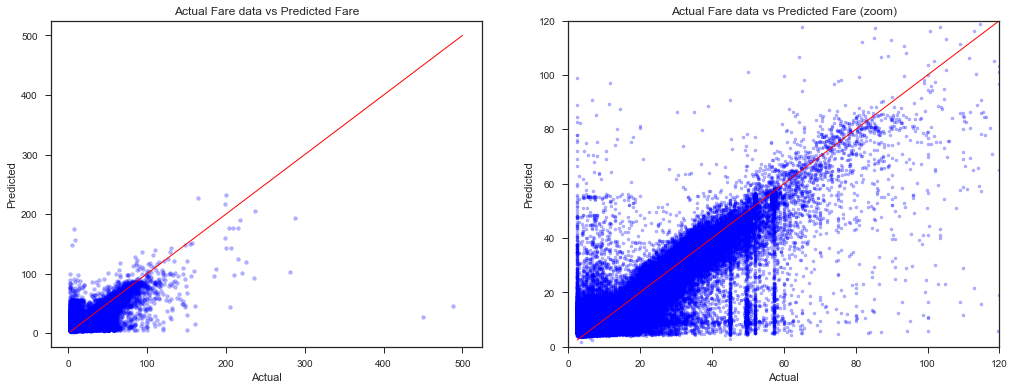

Wall time: 6.95 s


In [29]:
%%time

from lib import gfx  # gfx is another local module under the 'lib' directory
from sklearn import metrics
from math import sqrt

# The prediction is calculated as the arithmetic mean of both model's predictions
# y_pred = np.expm1(xg_reg.predict(X_test))
# y_pred = xg_reg.predict(X_test)
y_pred = xg_reg.predict(test_dmatrix)

rmse_score = sqrt(metrics.mean_squared_error(y_test, y_pred))
print('\n>>> RMSE Score:', rmse_score, '\n') # 3M -> 3.6119

# Plot Actual fare data against Predicted fare
gfx.plot_actual_vs_predicted(y, y_test, y_pred)

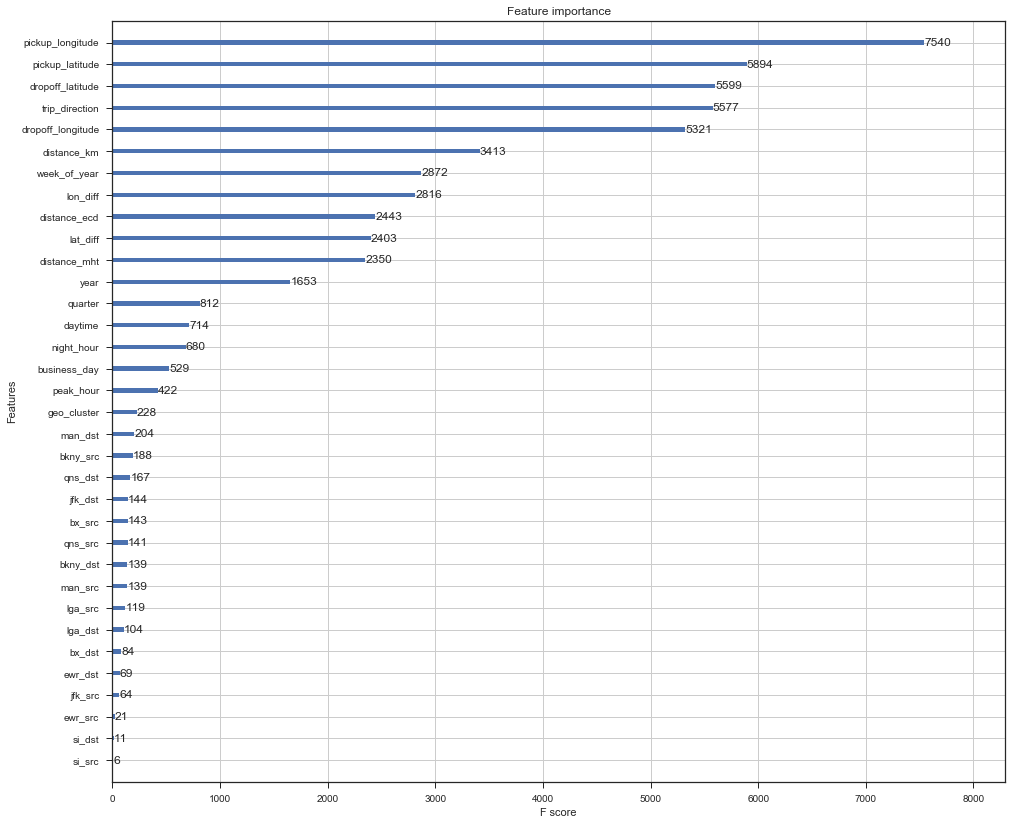

In [30]:
plt.rcParams['figure.figsize'] = [16, 14]
xgb.plot_importance(xg_reg)
plt.show()

In [31]:
# xgb.plot_tree(xg_reg, num_trees=0)

# 5. Submission

## 5.1 Feature Engineering for the Submission dataset

In [32]:
# Add ride-based features for the test set, copying from the training set
def test_add_ride_statistics(test, train):
    short_train_df = train[['year','month','day','hour','rides_per_hour']]
    tmp_hour = short_train_df.groupby(['year','month','day','hour']).agg({'rides_per_hour' : [np.mean]}).reset_index()
    tmp_hour.columns = ['year','month','day','hour','rides_per_hour']
    test = pd.merge(test, tmp_hour, how='left', on=['year','month','day','hour']) 

    short_train_df = train[['year','month','day','rides_per_day']]
    tmp_day = short_train_df.groupby(['year','month','day']).agg({'rides_per_day' : [np.mean]}).reset_index()
    tmp_day.columns = ['year','month','day','rides_per_day']
    test = pd.merge(test, tmp_day, how='left', on=['year','month','day'])
    
    # At this point, there might be some NaNs laying around    
    test["rides_per_day"].fillna(method='ffill', inplace=True) 
    test["rides_per_hour"].fillna(method='ffill', inplace=True) 
    return test

In [33]:
# Add mean/median/min/max fare statistics for the test set
def test_add_statistics(test, train):
    # Score 7.82    
#     short_train_df = train[['year','month','day_of_week','hour','distance_km_round','taxis_per_hour','mean_fare','median_fare','min_fare','max_fare']]
#     tmp = short_train_df.groupby(['year','month','day_of_week','hour','distance_km_round','taxis_per_hour']).agg({'mean_fare':[np.mean],'median_fare':[np.mean],'min_fare':[np.mean],'max_fare':[np.mean]}).reset_index()
#     tmp.columns = ['year','month','day_of_week','hour','distance_km_round','taxis_per_hour','mean_fare','median_fare','min_fare','max_fare']    
#     test = pd.merge(test, tmp, how='left', on=['year','month','day_of_week','hour','distance_km_round','taxis_per_hour'])          

    # Score 6.59
    short_train_df = train[['hour','distance_km_round','taxis_per_hour','mean_fare','median_fare','min_fare','max_fare']]
    tmp = short_train_df.groupby(['hour','distance_km_round','taxis_per_hour']).agg({'mean_fare':[np.mean],'median_fare':[np.mean],'min_fare':[np.mean],'max_fare':[np.mean]}).reset_index()
    tmp.columns = ['hour','distance_km_round','taxis_per_hour','mean_fare','median_fare','min_fare','max_fare']
    test = pd.merge(test, tmp, how='left', on=['hour','distance_km_round','taxis_per_hour'])  

    # Score 7.58
#     short_train_df = train[['day_of_week','hour','distance_km_round','taxis_per_hour','mean_fare','median_fare','min_fare','max_fare']]
#     tmp = short_train_df.groupby(['day_of_week','hour','distance_km_round','taxis_per_hour']).agg({'mean_fare':[np.mean],'median_fare':[np.mean],'min_fare':[np.mean],'max_fare':[np.mean]}).reset_index()
#     tmp.columns = ['day_of_week','hour','distance_km_round','taxis_per_hour','mean_fare','median_fare','min_fare','max_fare']
#     test = pd.merge(test, tmp, how='left', on=['day_of_week','hour','distance_km_round','taxis_per_hour'])  
    
    return test

In [34]:
def test_add_cost_per_km(test):    
    test['cost_per_km'] = test.apply(lambda row: row['distance_km_round'] / row['mean_fare'], axis=1)
    test['cost_per_km'] = test['cost_per_km'].astype('float32')
    return test

## 5.2 Feature Selection for the Submission dataset

In [35]:
# loads the test dataset used for submission
col_types = {
    'key': 'str',
    'pickup_datetime': 'str', 
    'pickup_longitude': 'float32',
    'pickup_latitude': 'float32',
    'dropoff_longitude': 'float32',
    'dropoff_latitude': 'float32',
    'passenger_count': 'uint8'
}

test_df = pd.read_csv('data/test.csv', usecols=list(col_types.keys()), dtype=col_types)
test_df['pickup_datetime'] = test_df['pickup_datetime'].str.slice(0, 16)
test_df['pickup_datetime'] = pd.to_datetime(test_df['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')

display(test_df.head(3))
print('>>> test_df shape:', test_df.shape)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:00+00:00,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:00+00:00,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:00+00:00,-73.982521,40.751259,-73.979652,40.746140,1


>>> test_df shape: (9914, 7)


In [36]:
# Add common features
if (use_feature_calendar):
    test_df = add_calendar(test_df)
        
if (use_feature_hour_statistics):
    test_df = add_hour_statistics(test_df)            
        
if (use_feature_distance_km):    
    test_df = add_distance_km(test_df)

if (use_feature_distances):    
    test_df = add_distances_mht_ecd(test_df)

if (use_feature_trip_direction):
    test_df = add_compass_bearing(test_df)        
    
if (use_feature_geo_coords_rounded):    
    test_df = add_geo_coords_rounded(test_df)

if (use_feature_geo_cluster):    
    test_df = add_geo_cluster(test_df, train_df)

if (use_feature_geo_diff):    
    test_df = add_geo_diff(test_df)

if (use_feature_airports):    
    test_df = add_airports(test_df)

if (use_feature_locations):    
    test_df = add_locations(test_df)
    
if (use_feature_ride_statistics):    
    test_df = test_add_ride_statistics(test_df, train_df)

if (use_feature_fare_statistics): 
    test_df = add_fare_statistics(test_df, train_df)        
    # print(test_df.isnull().sum())               # check missing data
    # test_df = test_df.fillna(test_df.mean())    # handle missing data    
        
if (use_feature_cost_per_km): 
    test_df = test_add_cost_per_km(test_df, train_df)         
    
# Remove weak features
test_df.drop(bad_features_list, axis=1, inplace=True)    

display(test_df.head(3))

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,year,quarter,week_of_year,business_day,daytime,peak_hour,night_hour,distance_km,distance_mht,distance_ecd,trip_direction,geo_cluster,lon_diff,lat_diff,jfk_src,jfk_dst,ewr_src,ewr_dst,lga_src,lga_dst,man_src,man_dst,qns_src,qns_dst,bkny_src,bkny_dst,bx_src,bx_dst,si_src,si_dst
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:00+00:00,-73.973320,40.763805,-73.981430,40.743835,2015,1,5,1,1,0,0,2.323000,0.028080,0.021554,197.102997,2,-0.008110,-0.019970,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:00+00:00,-73.986862,40.719383,-73.998886,40.739201,2015,1,5,1,1,0,0,2.425000,0.031841,0.023180,335.312012,0,-0.012024,0.019817,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:00+00:00,-73.982521,40.751259,-73.979652,40.746140,2011,4,40,0,1,0,0,0.618000,0.007988,0.005868,156.996994,0,0.002869,-0.005119,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0


In [37]:
# DEBUG: NaNs
# print(test_df.isnull().sum())                             # check missing data
# display(test_df[test_df.isnull().any(axis=1)].head())     # print NaN rows      
# display(test_df.iloc[10:13])                              # print specific rows

display(test_df.describe())
# print(test_df.info())

print_mem_usage(test_df)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,year,quarter,week_of_year,business_day,daytime,peak_hour,night_hour,distance_km,distance_mht,distance_ecd,trip_direction,geo_cluster,lon_diff,lat_diff,jfk_src,jfk_dst,ewr_src,ewr_dst,lga_src,lga_dst,man_src,man_dst,qns_src,qns_dst,bkny_src,bkny_dst,bx_src,bx_dst,si_src,si_dst
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.976181,40.750954,-73.974945,40.751553,2011.815816,2.573532,28.161892,0.727960,0.515534,0.200424,0.400746,3.435371,0.045481,0.035146,151.149750,0.998890,0.001066,0.000702,0.016946,0.006355,0.000000,0.001210,0.019467,0.012205,0.950777,0.939984,0.185294,0.208090,0.274259,0.280109,0.001009,0.009280,0.000202,0.000303
std,0.042799,0.033542,0.039093,0.035436,1.803347,1.097069,14.523575,0.445033,0.499784,0.400338,0.490074,3.972372,0.055975,0.042459,104.614883,0.980954,0.043501,0.033826,0.129075,0.079466,0.000000,0.034772,0.138168,0.109805,0.216345,0.237529,0.388555,0.405962,0.446162,0.449075,0.031745,0.095889,0.014203,0.017394
min,-74.252190,40.573143,-74.263245,40.568974,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.849174,-0.633213,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-73.992500,40.736125,-73.991249,40.735253,2010.000000,2.000000,17.000000,0.000000,0.000000,0.000000,0.000000,1.298000,0.017006,0.013261,41.424998,0.000000,-0.011496,-0.014214,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-73.982327,40.753052,-73.980015,40.754065,2012.000000,3.000000,29.000000,1.000000,1.000000,0.000000,0.000000,2.217000,0.029110,0.022423,165.851501,1.000000,0.001682,0.000158,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-73.968012,40.767113,-73.964062,40.768757,2014.000000,4.000000,40.000000,1.000000,1.000000,0.000000,1.000000,4.045750,0.052960,0.040167,220.580750,2.000000,0.014906,0.015326,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,-72.986534,41.709557,-72.990967,41.696682,2015.000000,4.000000,53.000000,1.000000,1.000000,1.000000,1.000000,99.996002,1.479969,1.057334,359.925995,3.000000,0.392708,0.237133,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


>>> Memory usage: memory usage: 1.5 MB


In [38]:
import unittest

L1 = train_df.columns.tolist()
L2 = test_df.columns.tolist()
print('>>> Only *fare_amount* can show up as the difference between both datasets.\n>>> Found:', list(set(L1) - set(L2)))
print('>>> Number of Features for training=', len(L1), 'and testing=', len(L2))

tc = unittest.TestCase('__init__')
tc.assertEqual(len(L1) == len(L2), True)  # test_df includes 'key', so this works

>>> Only *fare_amount* can show up as the difference between both datasets.
>>> Found: ['fare_amount']
>>> Number of Features for training= 36 and testing= 36


## 5.3 Train & run the final Model on the Submission dataset

This step stores the final results in *submission.csv*:

In [39]:
%%time

### Select the submission data to be used on the final model
X = train_df.drop(['fare_amount', 'pickup_datetime'], axis=1)
y = train_df[['fare_amount']].values.ravel()

### Create and fit the model
train_dmatrix = xgb.DMatrix(data=X, label=y)
xg_reg = xgb.train(params=xgb_params, dtrain=train_dmatrix, num_boost_round=45)

### Predict fare
X_test = test_df.drop(['key', 'pickup_datetime'], axis=1)
# y_pred = np.expm1(xg_reg.predict(X_test))
y_pred = xg_reg.predict(xgb.DMatrix(X_test))

### Save submission file
submission_df = pd.read_csv('data/sample_submission.csv')
submission_df['fare_amount'] = y_pred
submission_df.to_csv('submission_xgb.csv', index=False)

display(submission_df.head())
print('>>> submission_df shape=', submission_df.shape)
print('>>> File saved sucessfully.')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.096301
1,2015-01-27 13:08:24.0000003,10.678128
2,2011-10-08 11:53:44.0000002,4.816511
3,2012-12-01 21:12:12.0000002,7.413318
4,2012-12-01 21:12:12.0000003,14.712519


>>> submission_df shape= (9914, 2)
>>> File saved sucessfully.
Wall time: 1min 51s


**Print total notebook runtime for debugging purposes:**

In [40]:
from datetime import timedelta

elapsed_time = (time.time() - start_time)
print('>>> Runtime:', str(timedelta(seconds=elapsed_time)))

>>> Runtime: 0:10:10.584389
